# Spectral Residual

마이크로소프트의 논문 "[Time-Series Anomaly Detection Service at Microsoft](https://arxiv.org/pdf/1906.03821.pdf)"에서 다루고 있는 Spectral Residual 알고리즘을 구현하고 실습해본다. 

Spectral Residual은 푸리에 변환을 이용하여 이미지 속 돌출(saliency) 부분을 추출하는데 사용된다.
시계열 역시 푸리에 변환으로 다양한 주기 성분들의 합으로 나타낼 수 있다.
여기선 numpy의 고속 푸리에변환(fft) 함수를 사용하며 논문에서 제시하는 SR 계산 과정을 수행한다.

SR 계산은 크게 세 단계로 구분된다.
(1) 푸리에 변환으로 log amplitude spectrum 추출
(2) spectral residual(잔차) 계산
(3) 역푸리에 변환으로 원래의 spatial domain 으로 변환

수학적으로 각 단계는 다음과 같이 표현된다.
1. A($f$) = $Amplitude$($F$($x$))
2. P($f$) = $Phase$($F$($x$))
3. L($f$) = $log$(A($f$))
4. AL($f$) = $h_q$($f$)·L($f$)
5. R($f$) = L($f$) - AL($f$)
6. S($x$) = ||$F$<sup>-1</sup>($exp$(R($f$)+$i$P($f$)))||

$F$와 $F$<sup>-1</sup>는 각각 푸리에 변환과 역푸리에 변환이다.
$Amplitude$는 푸리에 변환된 주파수에서 np.abs()로 진폭을 추출한 것이다.
$Phase$는 푸리에 변환된 주파수에서 np.angle()로 위상을 추출한 것이다.


위 과정을 통해 시계열 속에서 두드러지는 saliency map을 얻을 수 있다. 
적절한 threshold 값을 지정함으로써 시계열 데이터에 대해 anomaly detection을 수행할 수 있다.

- reference
    - (paper) https://arxiv.org/pdf/1906.03821.pdf
    - (source code) https://github.com/SeldonIO/alibi-detect
    - https://ballentain.tistory.com/3


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 푸리에 변환 과정 이해

### 1.1. 입력 신호 만들기
분석 대상이 되는 신호를 만들어주기 위해 35Hz와 10Hz를 갖는 두 신호를 생성해 하나의 신호(signal)로 더해준다.

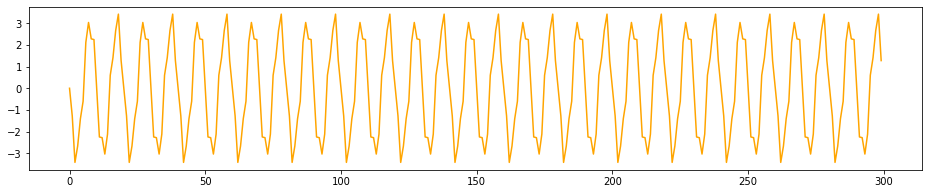

In [2]:
fs = 100 
t = np.arange(0, 3, 1 / fs)
f1 = 35
f2 = 10
signal = 0.6 * np.sin(2 * np.pi * f1 * t) + 3 * np.cos(2 * np.pi * f2 * t + np.pi/2)

plt.figure(figsize=(16, 3))
plt.plot(signal, c='orange')
plt.show()

### 1.2. 푸리에 변환

/data/venv/lib64/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


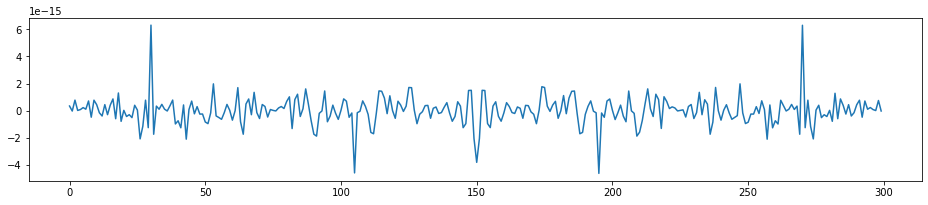

In [3]:
fft = np.fft.fft(signal) / len(signal)
plt.figure(figsize=(16, 3))
plt.plot(fft)
plt.show()

### 1.3. Amplitude 추출

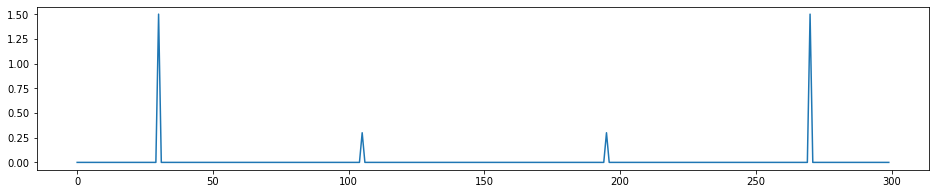

In [4]:
A = abs(fft) 
plt.figure(figsize=(16, 3))
plt.plot(A)
plt.show()

### 1.4. log of Amplitude

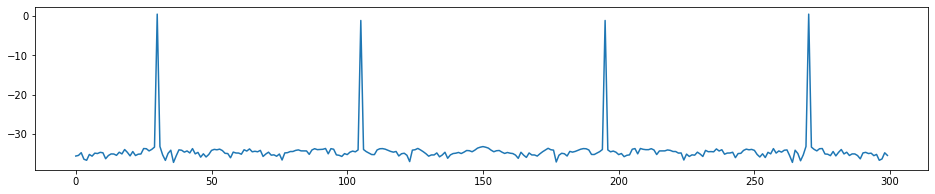

In [5]:
L = np.log(A)
plt.figure(figsize=(16, 3))
plt.plot(L)
plt.show()

### 1.5. convolution of log

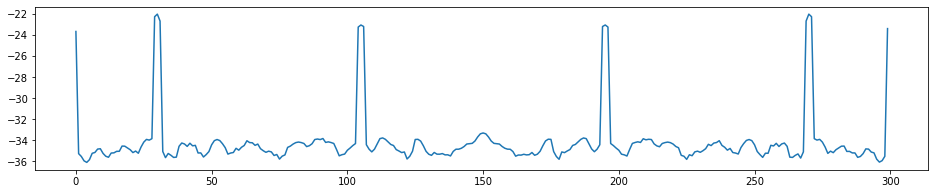

In [6]:
AL = np.convolve(L, np.ones(shape=(3))/3, 'same')
plt.figure(figsize=(16, 3))
plt.plot(AL)
plt.show()

### 1.6. residual of L and AL

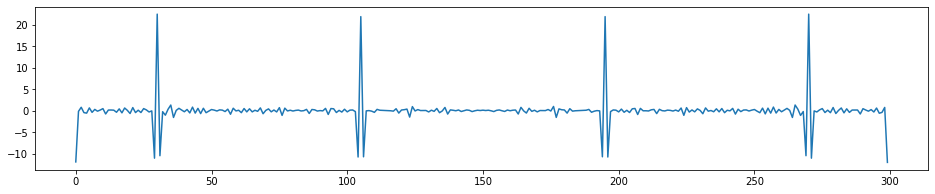

In [7]:
R = L - AL
plt.figure(figsize=(16, 3))
plt.plot(R)
plt.show()

### 1.7. Phase spectrum

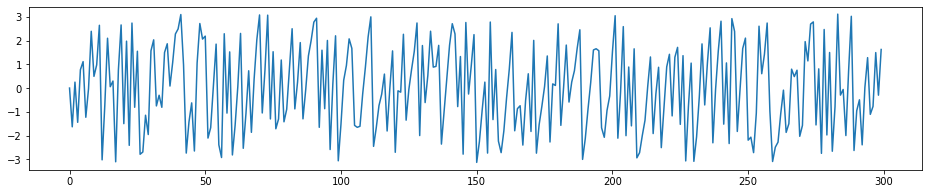

In [8]:
P = np.angle(fft)
plt.figure(figsize=(16, 3))
plt.plot(P)
plt.show()

### 1.8. Spectral Residual

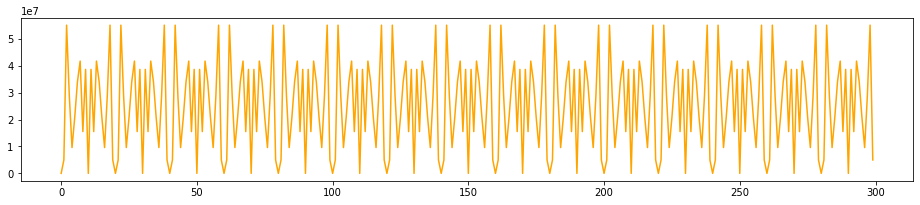

In [9]:
S = np.abs(np.fft.ifft(np.exp(R + 1j*P)))
plt.figure(figsize=(16, 3))
plt.plot(S, c='orange')
plt.show()

## 2. SR로 이상치 탐지하기

### 2.1. 이상치를 포함한 데이터

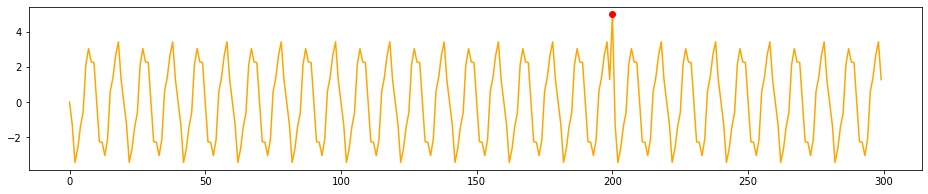

In [13]:
fs = 100 
t = np.arange(0, 3, 1 / fs)
f1 = 35
f2 = 10
signal = 0.6 * np.sin(2 * np.pi * f1 * t) + 3 * np.cos(2 * np.pi * f2 * t + np.pi/2)
signal[200] += 5

plt.figure(figsize=(16, 3))
plt.plot(signal, c='orange')
plt.plot(200, signal[200], 'ro')
plt.show()

### 2.2. Spectral Residual로 saliency map 구하기

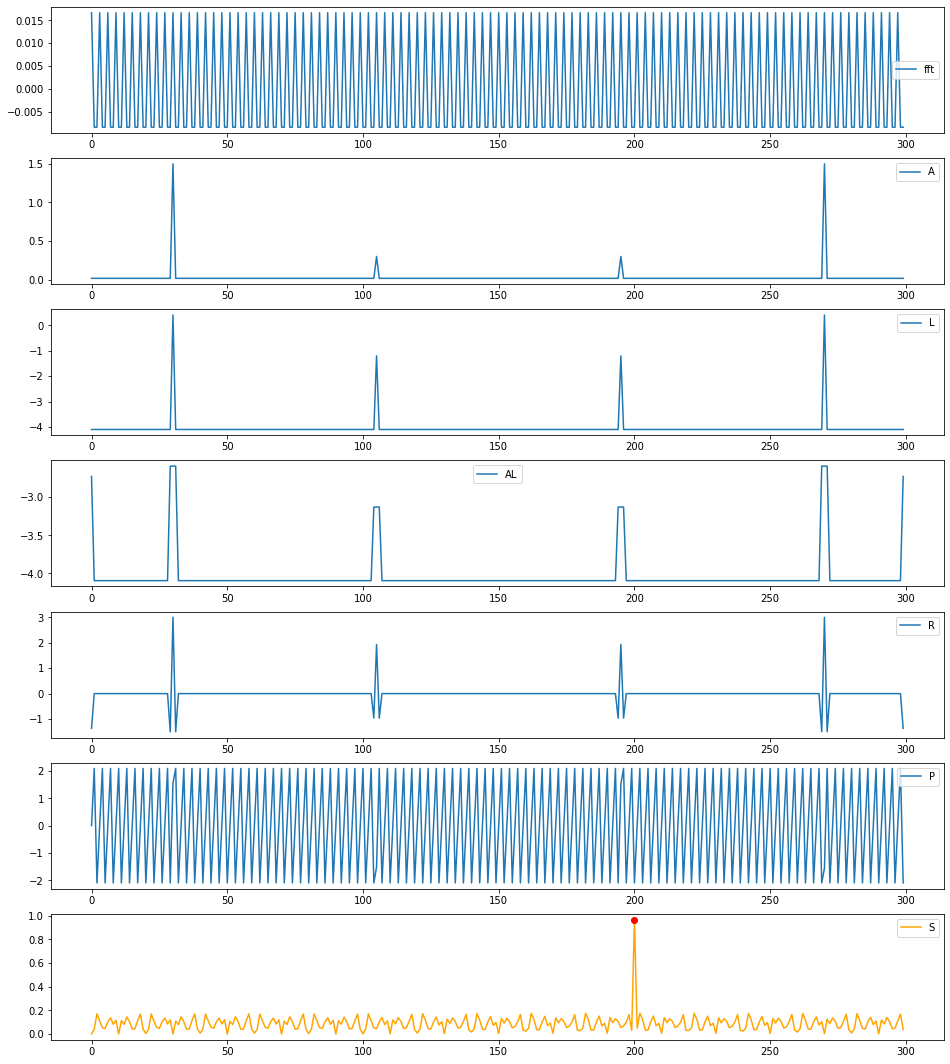

In [14]:
fft = np.fft.fft(signal) / len(signal)
A = abs(fft) 
L = np.log(A)
AL = np.convolve(L, np.ones(shape=(3))/3, 'same')
R = L - AL
P = np.angle(fft)
S = np.abs(np.fft.ifft(np.exp(R + 1j*P)))

fig, ax = plt.subplots(7, 1, figsize=(16, 19))
ax[0].plot(fft)
ax[0].legend(["fft"])
ax[1].plot(A)
ax[1].legend(["A"])
ax[2].plot(L)
ax[2].legend(["L"])
ax[3].plot(AL)
ax[3].legend(["AL"])
ax[4].plot(R)
ax[4].legend(["R"])
ax[5].plot(P)
ax[5].legend(["P"])
ax[6].plot(S, c='orange')
ax[6].plot(200, S[200], 'ro')
ax[6].legend(["S"])
plt.show()

원본 시계열의 이상치가 최종 Spectral Residual 결과 값에서 돌출되는 것을 확인할 수 있다.